In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Union, Any
import base64
from numpy.random import permutation
import os
import glob
import PIL
import io
from pprint import pprint

import anthropic
from datasets import load_dataset


/Users/loyalshababo/dev/plotreader/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def image_to_base64(image: Union[str, Any]):

    if isinstance(image, str):
        with open(image, "rb") as image_file:
            binary_data = image_file.read()
        
    else:
        image_data = io.BytesIO()
        image.save(image_data, format='PNG', optimize=True, quality=100)
        image_data.seek(0)
        binary_data = image_data.getvalue()
    
    
    base_64_encoded_data = base64.b64encode(binary_data)
    return base_64_encoded_data.decode('utf-8')

In [4]:
claude = anthropic.Anthropic()

In [5]:
ds = load_dataset("futurehouse/lab-bench", "FigQA")
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'ideal', 'distractors', 'canary', 'subtask', 'figure', 'figure-path'],
        num_rows: 181
    })
})

In [6]:
def get_randomized_options(sample):

    options = sample['distractors']
    options.append(sample['ideal'])
    options = permutation(options)

    return options

figqa_prompt_template = """
Question: {question}\n
Choose from the following answer options: {answer_options}
"""

In [7]:
dl_imagedir = "./data_images"
[os.remove(os.path.join(f)) for f in glob.glob(os.path.join(dl_imagedir,"*"))]

[]

## START INFERENCE HERE

In [96]:
sample_ind = 0

In [97]:
sample = ds['train'][sample_ind]

message_txt = figqa_prompt_template.format(question = sample['question'], answer_options=get_randomized_options(sample))

fig = sample['figure']
fig_resized_data = image_to_base64(fig.resize([dim//5 for dim in fig.size]))

In [98]:
message = claude.messages.create(
    model="claude-3-5-sonnet-20240620",
    max_tokens=1000,
    temperature=0,
    system="You are an expert scientist who is asked questions about figures from scientific papers. Do your best to answer them accurately.",
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": message_txt
                },
                {
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": "image/png",
                        "data": fig_resized_data
                    }
                }
            ]
        }
    ]
)


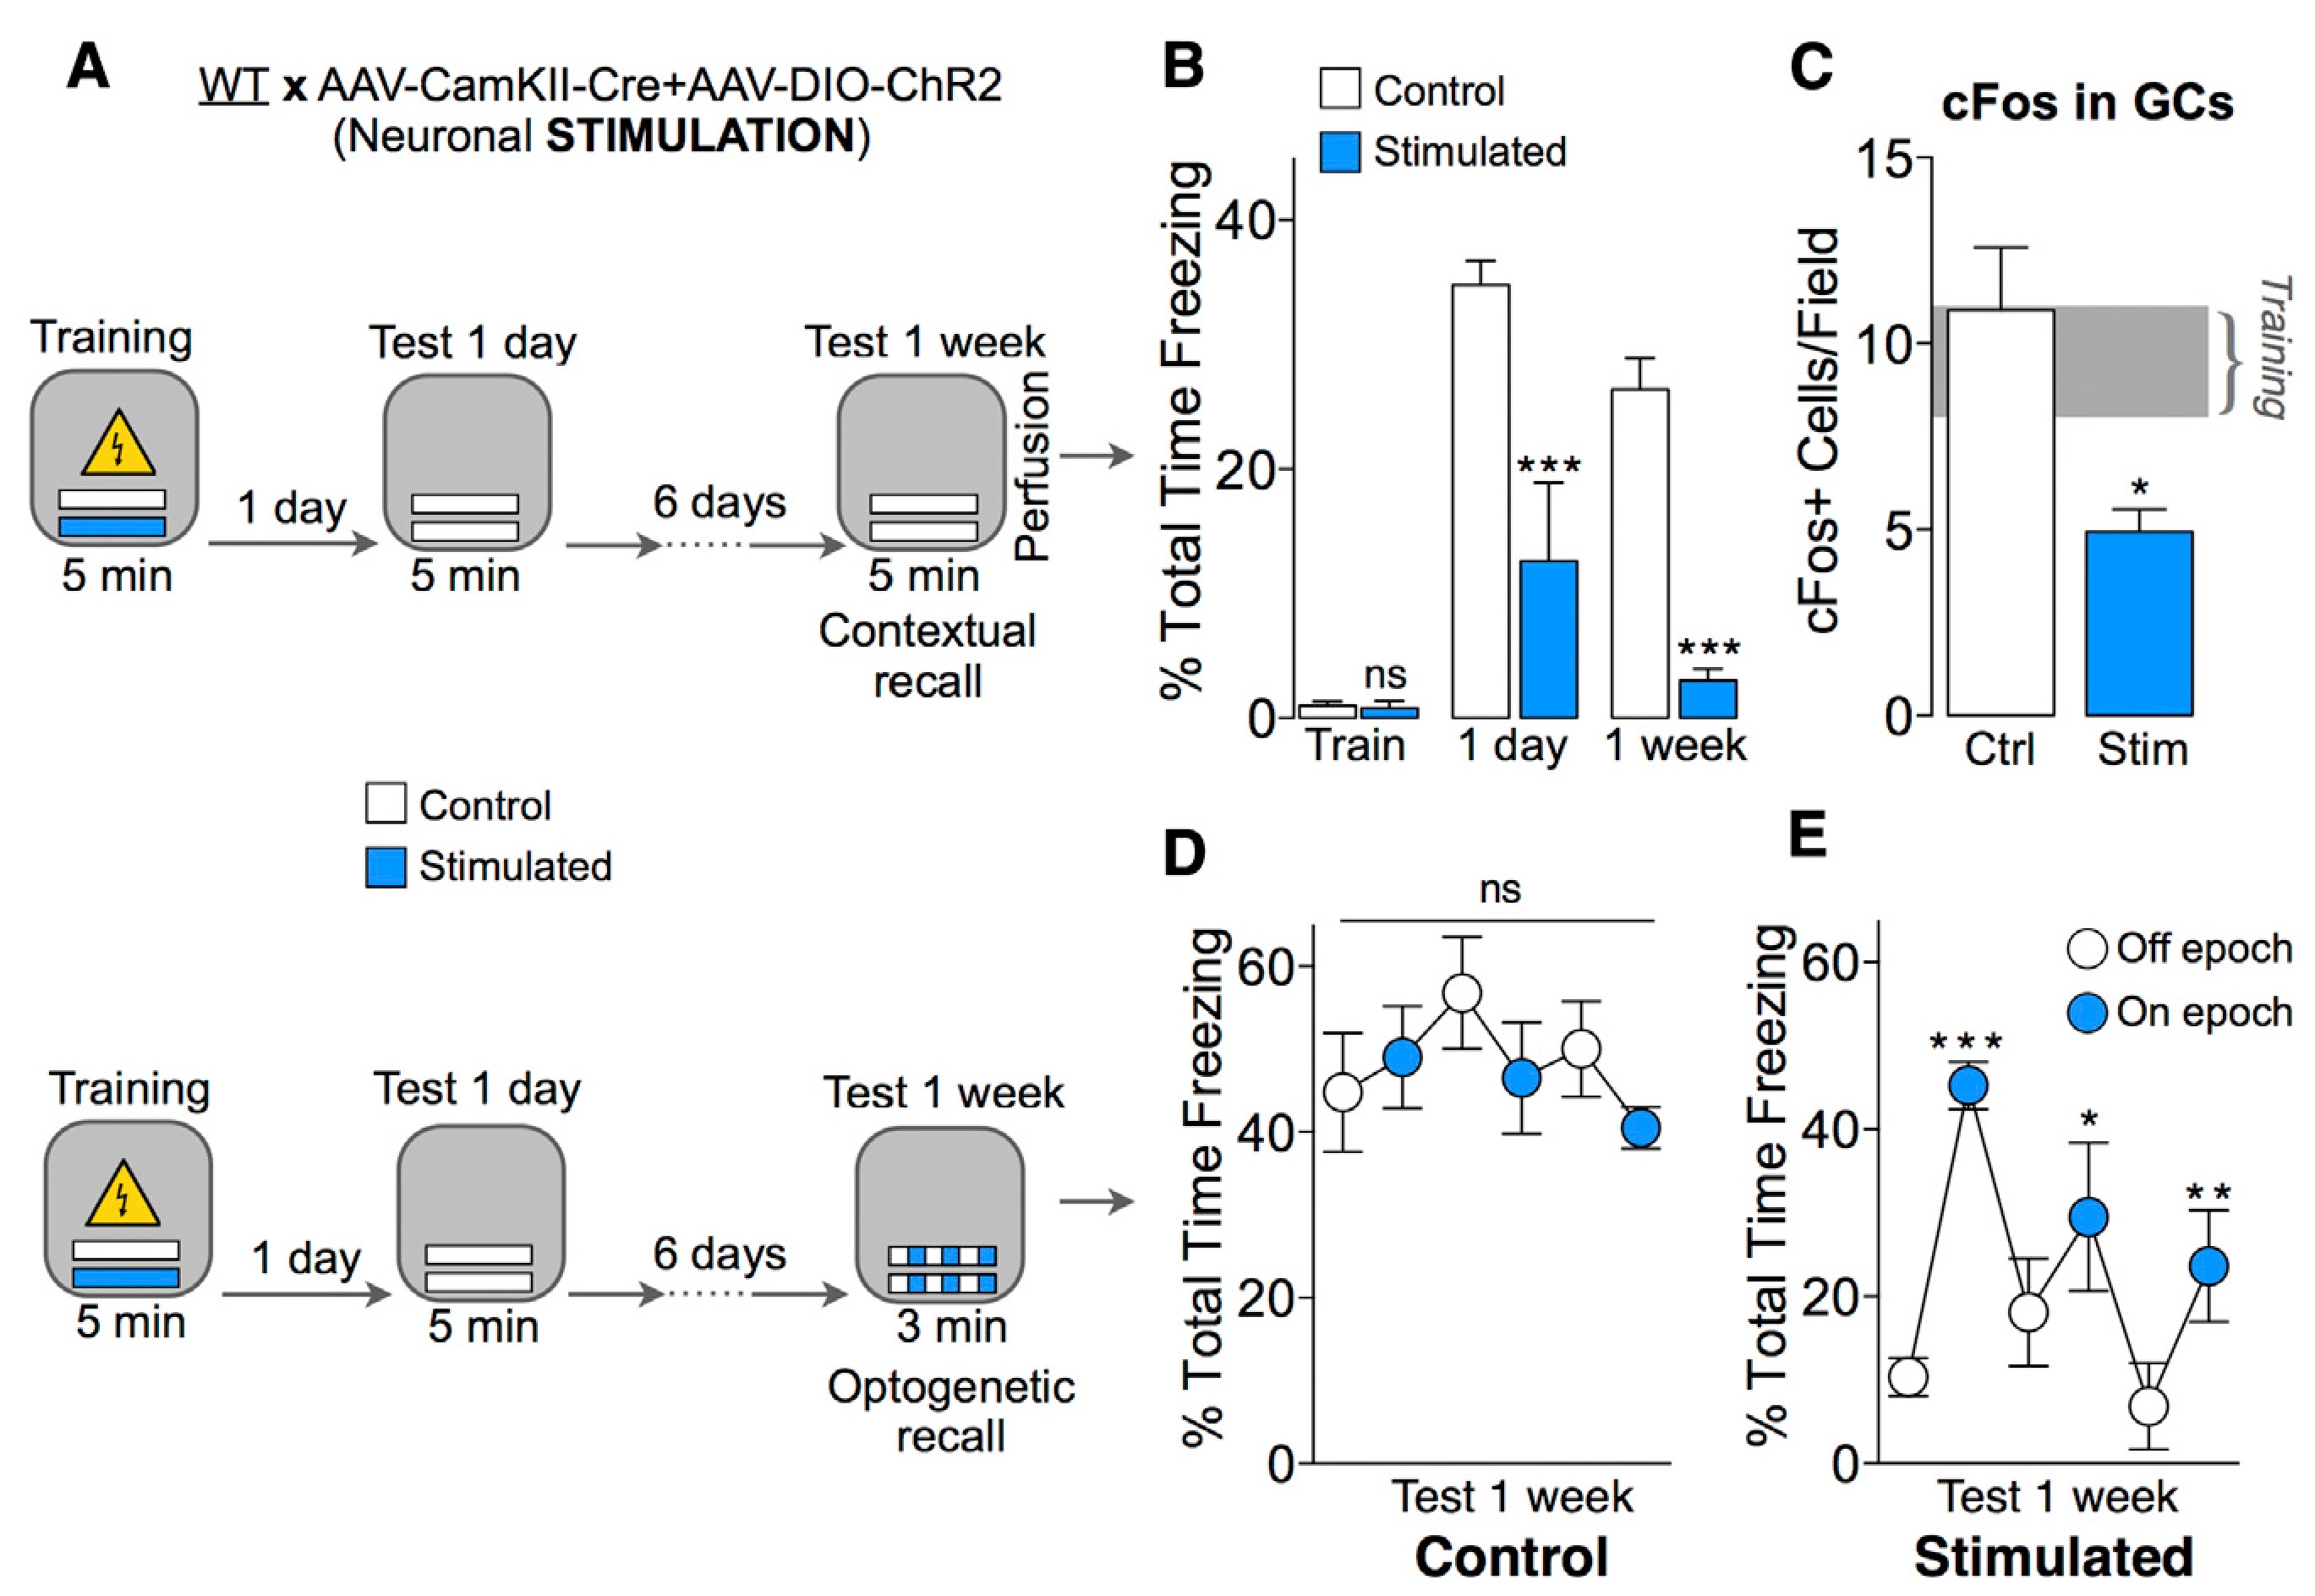

In [99]:
sample['figure']

In [100]:
sample['question']

'According to figure D, which of the following groups has a higher average % total time freezing across three stimulations? '

In [101]:
print("CLAUDE'S ANSWER:")
for block in message.content:
    try:
        pprint(block.text)
    except:
        pass

print("IDEAL ANSWER:")
print(sample['ideal'])

CLAUDE'S ANSWER:
("According to figure D, the 'Off epoch' group has a higher average % total "
 "time freezing across the three stimulations shown. The 'Off epoch' data "
 'points (represented by white circles) consistently show higher freezing '
 "percentages compared to the 'On epoch' data points (represented by blue "
 'circles) for all three time points measured during the "Test 1 week" period '
 'for the Control condition.\n'
 '\n'
 "Therefore, the correct answer from the given options is: 'Off epoch'")
IDEAL ANSWER:
Off epoch
